# Medical Image Classification: Hello World Deep Learning Tutorial

### Prepare data using the MD.ai python client, train using Keras

This is a high-level introduction into practical machine learning for purposes of medical image classification. The goal of this tutorial is to build a deep learning classifier to accurately differentiate between chest and abdominal X-rays. The model is trained using 75 images de-identified images obtained from Open-i.

Original github repo this is based on: https://github.com/ImagingInformatics/machine-learning

MD.ai annotator project URL: https://public.md.ai/annotator/project/PVq9raBJ

**How to use on Colab: in the menu, go to Runtime -> Change runtime type -> switch to Python 3, and turn on GPU.**

### Import the `mdai` library

On Colab, run the block below to install the `mdai` client library into your python environment.

In [3]:
!pip install --upgrade --quiet mdai

In [4]:
import mdai
import mdai.visualize as vis
from mdai import utils

### Create an `mdai` client

The mdai client requires an access token, which authenticates you as the user. To create a new token or select an existing token, navigate to the "Personal Access Tokens" tab on your user settings page at the specified MD.ai domain (e.g., public.md.ai).

**Important: keep your access tokens safe. Do not ever share your tokens.**

In [5]:
mdai_client = mdai.Client(domain='public.md.ai', access_token='')

Successfully authenticated to public.md.ai.


### Define project

Define a project you have access to by passing in the project id. The project id can be found in the URL in the following format: `https://public.md.ai/annotator/project/{project_id}`.

For example, `project_id` would be `PVq9raBJ` for `https://public.md.ai/annotator/project/PVq9raBJ`.

Specify optional `path` as the data directory (if left blank, will default to current working directory).

In [6]:
p = mdai_client.project('PVq9raBJ', path='data')

Using working directory for data.
Preparing annotations export for project PVq9raBJ...                                                
Preparing images export for project PVq9raBJ...                                                     


64.0kB [00:00, 30.0MB/s]                   


Success: annotations data for project PVq9raBJ ready.


2.59MB [00:00, 65.2MB/s]                   

Extracting archive: mdai_public_project_PVq9raBJ_images_2018-07-18-232128.zip
Success: images data for project PVq9raBJ ready.


### Set label ids

Selected label ids must be explicitly set by `Project#set_label_ids` method in order to prepare datasets.

In [7]:
p.show_label_groups_info()

Label Groups:
Name: Default group, Id: G_3lv
	
Labels:
Name: Abdomen, Id: L_yxv
Name: Chest, Id: L_dyy




In [8]:
label_ids = ['L_yxv', 'L_dyy']
p.set_label_ids(label_ids)

### Create the *Training* and *Validation* datasets

In [9]:
p.show_datasets_info() 

Datasets:
Name: TRAIN, Id: D_33v
Name: VAL, Id: D_vvp
Name: TEST, Id: D_oz1



In [10]:
# create training dataset 
train_dataset = p.get_dataset_by_name('TRAIN')
train_dataset.prepare() 
train_image_ids = train_dataset.get_image_ids()

# create the validation dataset 
val_dataset = p.get_dataset_by_name('VAL')
val_dataset.prepare()
val_image_ids = val_dataset.get_image_ids()

Dataset contains 65 annotations.
Dataset contains 10 annotations.


### Display a few images

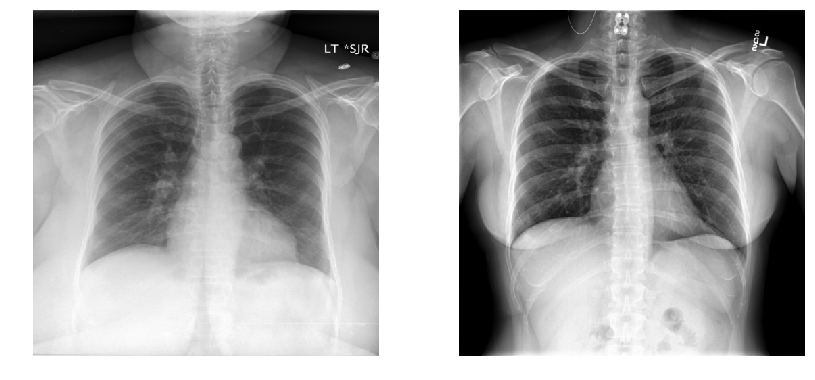

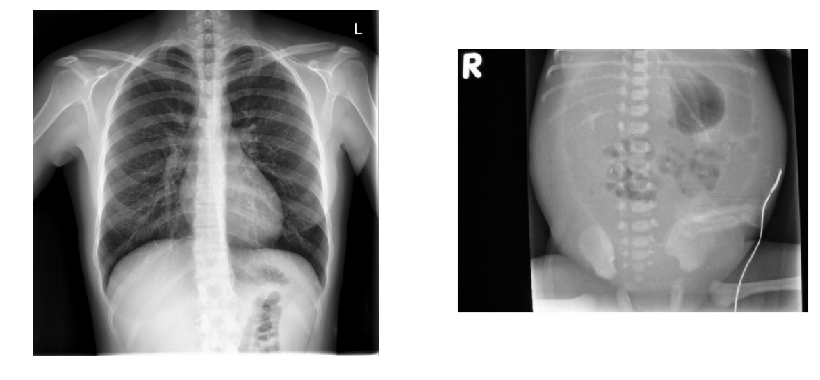

In [16]:
# visualize a few train images 
vis.display_images(train_image_ids[:2], cols=2)
vis.display_images(val_image_ids[:2], cols=2)

### Use Keras for training and validation

In [17]:
from keras import applications
from keras.models import Model, Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [18]:
# Define model parameters 

img_width = 256
img_height = 256
epoch = 5

params = {
    'dim': (img_width, img_height),
    'batch_size': 5,
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': True,
}

In [19]:
# Transfer Learning 
# Use the InceptionV3 pre-trained model as base model 

base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
model_top  = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(2, activation='softmax')) 

model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
import warnings
warnings.filterwarnings('ignore')

train_generator = utils.DataGenerator(train_dataset, **params)
val_generator = utils.DataGenerator(val_dataset, **params)

# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

history = model.fit_generator(
            generator=train_generator,
            epochs=epoch,
            callbacks=callbacks,
            verbose=1,            
            validation_data=val_generator,
            use_multiprocessing=True, 
            workers=6)         

Epoch 1/5
13/13 [==============================] - 14s 1s/step - loss: 0.4725 - acc: 0.7692 - val_loss: 0.2133 - val_acc: 0.9000
Epoch 2/5
13/13 [==============================] - 2s 179ms/step - loss: 0.1212 - acc: 0.9846 - val_loss: 0.1711 - val_acc: 0.9000
Epoch 3/5
13/13 [==============================] - 2s 156ms/step - loss: 0.0880 - acc: 0.9692 - val_loss: 0.1620 - val_acc: 0.9000
Epoch 4/5
13/13 [==============================] - 2s 163ms/step - loss: 0.0776 - acc: 0.9692 - val_loss: 0.1376 - val_acc: 0.9000
Epoch 5/5
13/13 [==============================] - 2s 153ms/step - loss: 0.0546 - acc: 0.9846 - val_loss: 0.1974 - val_acc: 0.9000


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


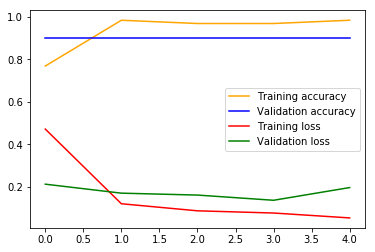

In [23]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

### Create the *Test* dataset

In [24]:
test_dataset = p.get_dataset_by_name('TEST')
test_dataset.prepare()

Dataset contains 2 annotations.


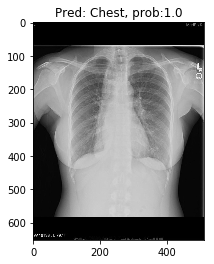

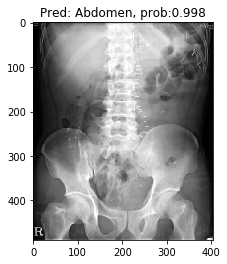

In [26]:
import numpy as np
from skimage.transform import resize

for image_id in test_dataset.image_ids: 
    
    image = vis.load_dicom_image(image_id, to_RGB=True)
    plt.figure()
    plt.imshow(image)
    
    image = resize(image, (img_width, img_height,3))
    x = np.expand_dims(image, axis=0)
    y_prob = model.predict(x) 
    y_classes = y_prob.argmax(axis=-1)
    title = 'Pred: ' + test_dataset.class_id_to_class_text(y_classes[0]) + ', prob:' + str(round(y_prob[0][y_classes[0]], 3))
    plt.title(title)
    
plt.show()